## Project 8 - Credit Risk - Part 2

### Notebook Content

1. Dataset Sampling
2. Models Training and Evaluation


## 1. Dataset Sampling
---

Import libraries:

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score 

from imblearn.over_sampling import (RandomOverSampler, SMOTE ,ADASYN, BorderlineSMOTE, SVMSMOTE)

Import filtered dataset:

In [14]:
train = pd.read_csv('dataset/ds_train.csv')
test = pd.read_csv('dataset/ds_test.csv')

In [16]:
X_train = train.drop(columns='Risk')            
y_train = train['Risk']

X_test = test.drop(columns='Risk')            
y_test = test['Risk']

Checking size and formats:

In [17]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (604, 9), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (604,), type: <class 'pandas.core.series.Series'>
X_test shape: (247, 9), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (247,), type: <class 'pandas.core.series.Series'>


Confusion Matrix plotting function:

In [7]:
def plot_cm(y_pred_):                    
    cnf_matrix = confusion_matrix(y_test, y_pred_)
    plt.figure(figsize=(4,3))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label', size=7)
    plt.xlabel('Predicted Label', size=7)
    plt.show()    

Classification Report function:

In [8]:
def class_report(y_pred_):                                                        
    print(classification_report(y_test, y_pred_, target_names = ['not risk','risk']))

### Dataset Sampling

We will create 5 different oversampled datasets:

In [19]:
oversampler_dict = {'random': RandomOverSampler(
                        sampling_strategy='auto',
                        random_state=42),

                    'smote': SMOTE(
                        sampling_strategy='auto',  
                        random_state=0,  
                        k_neighbors=5,
                        n_jobs=4),

                    'adasyn': ADASYN(
                        sampling_strategy='auto',  
                        random_state=0,  
                        n_neighbors=5,
                        n_jobs=4),

                    'border1': BorderlineSMOTE(
                        sampling_strategy='auto',  
                        random_state=0, 
                        k_neighbors=5,
                        m_neighbors=10,
                        kind='borderline-1',
                        n_jobs=4),

                    'border2': BorderlineSMOTE(
                        sampling_strategy='auto',  
                        random_state=0,  
                        k_neighbors=5,
                        m_neighbors=10,
                        kind='borderline-2',
                        n_jobs=4)
                        }

We will inspect the created Datasets:

Random Oversampled Dataset:

In [20]:
X_random, y_random = oversampler_dict['random'].fit_resample(X_train, y_train)

In [21]:
print(X_train.shape, X_random.shape)
print(y_train.value_counts(normalize=True))
print(y_random.value_counts(normalize=True))

(604, 9) (876, 9)
0    0.725166
1    0.274834
Name: Risk, dtype: float64
0    0.5
1    0.5
Name: Risk, dtype: float64


Smote Dataset:

In [22]:
X_smote, y_smote = oversampler_dict['smote'].fit_resample(X_train, y_train)

In [23]:
print(X_train.shape, X_smote.shape)
print(y_train.value_counts(normalize=True))
print(y_smote.value_counts(normalize=True))

(604, 9) (876, 9)
0    0.725166
1    0.274834
Name: Risk, dtype: float64
0    0.5
1    0.5
Name: Risk, dtype: float64


Adasyn Dataset:

In [24]:
X_adasyn, y_adasyn = oversampler_dict['adasyn'].fit_resample(X_train, y_train)

In [25]:
print(X_train.shape, X_adasyn.shape)
print(y_train.value_counts(normalize=True))
print(y_adasyn.value_counts(normalize=True))

(604, 9) (853, 9)
0    0.725166
1    0.274834
Name: Risk, dtype: float64
0    0.513482
1    0.486518
Name: Risk, dtype: float64


Border1 Dataset:

In [26]:
X_border1, y_border1 = oversampler_dict['border1'].fit_resample(X_train, y_train)

In [27]:
print(X_train.shape, X_border1.shape)
print(y_train.value_counts(normalize=True))
print(y_border1.value_counts(normalize=True))

(604, 9) (876, 9)
0    0.725166
1    0.274834
Name: Risk, dtype: float64
0    0.5
1    0.5
Name: Risk, dtype: float64


Border2 Dataset:

In [28]:
X_border2, y_border2 = oversampler_dict['border2'].fit_resample(X_train, y_train)

In [29]:
print(X_train.shape, X_border2.shape)
print(y_train.value_counts(normalize=True))
print(y_border2.value_counts(normalize=True))

(604, 9) (876, 9)
0    0.725166
1    0.274834
Name: Risk, dtype: float64
0    0.5
1    0.5
Name: Risk, dtype: float64


## 2. Models Training and Evaluation
---

### Model - Gradient Boosting Classifier

In [10]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

We will perform a Randomized Search with Cross Validation:

In [30]:
gbm = GradientBoostingClassifier(random_state=42)

param_grid = dict(                                               
                  n_estimators=stats.randint(10, 200),
                  min_samples_split=stats.uniform(0, 1),
                  learning_rate=stats.loguniform(0.0001, 0.1),
                  max_depth=stats.randint(1, 5),
                  loss=('deviance', 'exponential'),
                  )

search = RandomizedSearchCV(gbm, 
                            param_grid, 
                            scoring='roc_auc', 
                            cv=5,                
                            n_iter = 60,         
                            random_state=42,
                            refit=True,         
                            )

We define a function to perform Random Search, run the model with the best hyperparameters and print the Confusion Matrix and Classification Report:

In [12]:
def run_model(x_data, y_data):    

    search.fit(x_data, y_data)

    print(search.best_params_)
    print(search.best_score_)

    X_train_prob = search.predict_proba(x_data)[:,1]     
    X_test_prob = search.predict_proba(X_test)[:,1]

    print('Train roc_auc: ', roc_auc_score(y_data, X_train_prob))
    print('Test roc_auc: ', roc_auc_score(y_test, X_test_prob))

    X_train_pred = search.predict(x_data)              
    X_test_pred = search.predict(X_test)

    plot_cm(X_test_pred)

    class_report(X_test_pred)

Original Dataset:

{'learning_rate': 0.08918040138190564, 'loss': 'exponential', 'max_depth': 3, 'min_samples_split': 0.8164318732193839, 'n_estimators': 153}
0.7503702663738621
Train roc_auc:  0.854328271992078
Test roc_auc:  0.7493461203138623


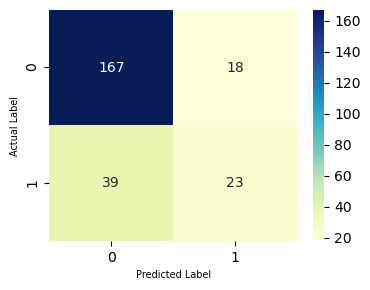

              precision    recall  f1-score   support

    not risk       0.81      0.90      0.85       185
        risk       0.56      0.37      0.45        62

    accuracy                           0.77       247
   macro avg       0.69      0.64      0.65       247
weighted avg       0.75      0.77      0.75       247



In [13]:
run_model(X_train, y_train)

Random Oversampled Dataset:

{'learning_rate': 0.020736445177905023, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 0.005522117123602399, 'n_estimators': 148}
0.8620326006934549
Train roc_auc:  0.9492764954859155
Test roc_auc:  0.751438535309503


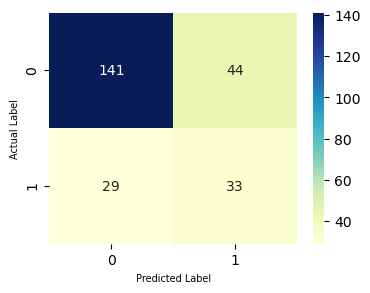

              precision    recall  f1-score   support

    not risk       0.83      0.76      0.79       185
        risk       0.43      0.53      0.47        62

    accuracy                           0.70       247
   macro avg       0.63      0.65      0.63       247
weighted avg       0.73      0.70      0.71       247



In [73]:
run_model(X_random, y_random)

Smote Dataset:

{'learning_rate': 0.020736445177905023, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 0.005522117123602399, 'n_estimators': 148}
0.8282060416072955
Train roc_auc:  0.9343372740351535
Test roc_auc:  0.7342632955536181


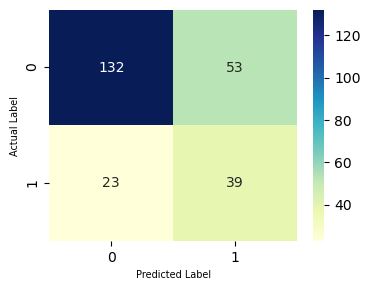

              precision    recall  f1-score   support

    not risk       0.85      0.71      0.78       185
        risk       0.42      0.63      0.51        62

    accuracy                           0.69       247
   macro avg       0.64      0.67      0.64       247
weighted avg       0.74      0.69      0.71       247



In [75]:
run_model(X_smote, y_smote)

Adasyn Dataset:

{'learning_rate': 0.020736445177905023, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 0.005522117123602399, 'n_estimators': 148}
0.8123215432261963
Train roc_auc:  0.9330857677284481
Test roc_auc:  0.7349607672188317


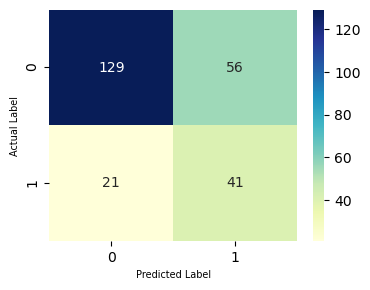

              precision    recall  f1-score   support

    not risk       0.86      0.70      0.77       185
        risk       0.42      0.66      0.52        62

    accuracy                           0.69       247
   macro avg       0.64      0.68      0.64       247
weighted avg       0.75      0.69      0.71       247



In [76]:
run_model(X_adasyn, y_adasyn) 

Border1 Dataset:

{'learning_rate': 0.09744534538859262, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 0.5582934536070976, 'n_estimators': 169}
0.8320503229790065
Train roc_auc:  0.9197681449511063
Test roc_auc:  0.7149956408020923


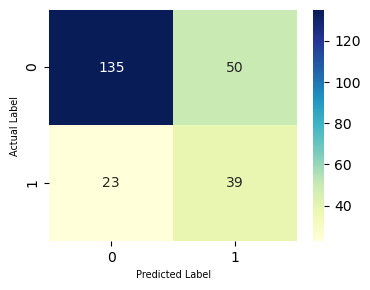

              precision    recall  f1-score   support

    not risk       0.85      0.73      0.79       185
        risk       0.44      0.63      0.52        62

    accuracy                           0.70       247
   macro avg       0.65      0.68      0.65       247
weighted avg       0.75      0.70      0.72       247



In [77]:
run_model(X_border1, y_border1)

Border2 Dataset:

{'learning_rate': 0.020736445177905023, 'loss': 'exponential', 'max_depth': 4, 'min_samples_split': 0.005522117123602399, 'n_estimators': 148}
0.8245366082454639
Train roc_auc:  0.9306806572006422
Test roc_auc:  0.7247602441150827


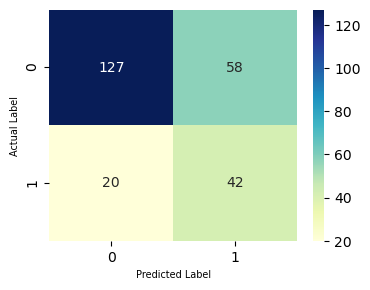

              precision    recall  f1-score   support

    not risk       0.86      0.69      0.77       185
        risk       0.42      0.68      0.52        62

    accuracy                           0.68       247
   macro avg       0.64      0.68      0.64       247
weighted avg       0.75      0.68      0.70       247



In [78]:
run_model(X_border2, y_border2)

The models run on the Adasyn sampled Dataset and on Border2 sampled Dataset showed the best results.